In [3]:
# !pip install --upgrade pip
# !pip install pytorch-lightning
# !pip install ray-lightning

# !sudo apt-get update
# !sudo apt-get install -y build-essential curl unzip psmisc

# # If you are not using Anaconda, you need the following.
# !sudo apt-get install python3-dev  # For Python 3.

# !pip install cython==0.29.0

# !pip3 uninstall -y ray # clean removal of previous install, otherwise version number may cause pip not to upgrade
# !pip3 install https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-0.9.0.dev0-cp37-cp37m-manylinux1_x86_64.whl

     |████████████████████████████████| 2.1 MB 6.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.5/582.5 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 KB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.1/136.1 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 KB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.8/271.8 KB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 KB 10.0 MB/s eta 0:00:00
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     

## Load the data

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

import numpy as np
import pandas as pd
from functools import partial
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from torch.utils.data import Dataset, DataLoader
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split

import pytorch_lightning as pl

train_path = "/content/gdrive/MyDrive/Classes/STATS 503/STATS503 Project/Heart Data/heart_subsampled/train.csv"
test_path = "/content/gdrive/MyDrive/Classes/STATS 503/STATS503 Project/Heart Data/heart_subsampled/test.csv"
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(len(train), len(test))
train.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
25557 6390


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,AgeCategory,PhysicalActivity,...,SkinCancer,Sex_Male,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,0,56.55,0,0,0,0.0,0.0,1,62,0,...,0,0,0,0,0,0,1,0,1,0
1,0,27.46,1,0,0,1.0,5.0,0,47,1,...,0,0,0,0,0,0,1,0,0,0
2,0,25.75,0,0,0,0.0,0.0,0,27,1,...,0,0,0,0,0,0,1,0,0,0
3,0,30.90,0,1,0,0.0,3.0,0,52,1,...,0,0,0,0,0,0,1,0,0,0
4,1,28.70,0,0,0,0.0,0.0,0,47,1,...,0,1,0,0,0,1,0,0,0,0


# Dataset and Loader

In [5]:
class HeartDataModule(pl.LightningDataModule):
  def __init__(self, data_dir, use_sample=False):
      super().__init__()
      self.train_csv = data_dir + 'train.csv'
      self.test_csv = data_dir + 'test.csv'
      self.use_sample = use_sample
      self.setup()

  def setup(self, stage = None):
    train_df = pd.read_csv(self.train_csv)
    test_df = pd.read_csv(self.test_csv)

    if self.use_sample:
      train_df = train_df.sample(n=5000, random_state=1)
      val_df = test_df.sample(n=1000, random_state=1, replace=False)
      test_df = test_df.sample(n=1000, random_state=1)
    else:
      test_df, val_df = train_test_split(test_df, test_size=0.2, random_state=1)

    train_target = torch.tensor(train_df['HeartDisease'].values.astype(np.float32))
    train = torch.tensor(train_df.drop('HeartDisease', axis=1).values.astype(np.float32))
    self.train_tensor = data_utils.TensorDataset(train, train_target)
    
    val_target = torch.tensor(val_df['HeartDisease'].values.astype(np.float32))
    val = torch.tensor(val_df.drop('HeartDisease', axis=1).values.astype(np.float32)) 
    self.val_tensor = data_utils.TensorDataset(val, val_target)

    test_target = torch.tensor(test_df['HeartDisease'].values.astype(np.float32))
    test = torch.tensor(test_df.drop('HeartDisease', axis=1).values.astype(np.float32)) 
    self.test_tensor = data_utils.TensorDataset(test, test_target)
   
  def train_dataloader(self):
    return DataLoader(self.train_tensor, batch_size=64, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_tensor, batch_size=64, shuffle=False)

  def test_dataloader(self):
    return DataLoader(self.test_tensor, batch_size=64, shuffle=True)

In [6]:
data_dir = "/content/gdrive/MyDrive/Classes/STATS 503/STATS503 Project/Heart Data/heart_subsampled/"
heart_data = HeartDataModule(data_dir, use_sample=True)
train_features, train_labels = next(iter(heart_data.train_dataloader()))

In [5]:
print(train_features.shape, train_labels.shape)

torch.Size([64, 23]) torch.Size([64])


# Model

In [7]:
class VanillaLightningNN(pl.LightningModule):
  def __init__(self, config):
    super(VanillaLightningNN, self).__init__()
    self.lr = config['lr']
    self.fc1 = nn.Linear(23, config['l1'])
    self.fc2 = nn.Linear(config['l1'], config['l2'])
    self.dropout = nn.Dropout(0.25)
    self.fc3 = nn.Linear(config['l2'], config['l3'])
    self.fc4 = nn.Linear(config['l3'], 1)
  
  def forward(self, x):
    x = self.dropout(x)
    x = self.fc1(x)
    x = torch.relu(self.fc2(x))
    x = self.dropout(x)
    x = torch.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=self.lr)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
    return [optimizer], [lr_scheduler]

  def training_step(self, batch, batch_idx):
    inputs, labels = batch
    outputs = self(inputs).float()
    criterion = nn.BCELoss()
    loss = criterion(outputs, labels.unsqueeze(1))
    total = labels.size(0)
    correct = (outputs.round() == labels).sum().item()
    tune.report(loss=loss, accuracy=correct / total)
    return loss
  
  def validation_step(self, batch, batch_idx):
    inputs, labels = batch
    total = labels.size(0)
    predicted = self(inputs).float()
    criterion = nn.BCELoss()
    val_loss = criterion(predicted, labels.unsqueeze(1))
    self.log("val_loss", val_loss)
    correct = (predicted.round() == labels).sum().item()
    tune.report(loss=val_loss, accuracy= correct / total)

  def test_step(self, batch, batch_idx):
    inputs, labels = batch
    predicted = self(inputs).float()
    total = labels.size(0)
    correct = (predicted.round() == labels).sum().item()
    self.log("test_accuracy", correct / total)

  def predict_step(self, batch, batch_idx):
    inputs, labels = batch
    pred = self(inputs)
    return pred

Tune on sample

In [8]:
def train_heart(config):
  model = VanillaLightningNN(config)

  # Create the Tune Reporting Callback
  metrics = {"loss": "ptl/val_loss", "acc": "ptl/val_accuracy"}

  data_dir = "/content/gdrive/MyDrive/Classes/STATS 503/STATS503 Project/Heart Data/heart_subsampled/"
  heart_data = HeartDataModule(data_dir, use_sample=True)
  trainer = pl.Trainer(max_epochs=10)
  trainer.fit(model, heart_data)

In [9]:
config = {
    "l1": tune.choice([32, 64, 128]),
    "l2": tune.choice([64, 128, 256]),
    "l3": tune.choice([64, 128, 256]),
    "lr": tune.loguniform(1e-4, 1e-1)
}

scheduler = ASHAScheduler(
        time_attr='training_iteration',
        metric="accuracy",
        mode="max",
        grace_period=10,
        reduction_factor=2,
        brackets=5
        )

reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])

analysis = tune.run(
        train_heart,
        config=config,
        num_samples=10,
        resources_per_trial={"cpu": 2, "gpu": 0},
        progress_reporter=reporter,
        scheduler=scheduler,
        checkpoint_at_end=False,
        name="tune_heart")

2022-04-21 23:43:40,451	INFO resource_spec.py:234 -- Available RAM
2022-04-21 23:43:40,452	INFO resource_spec.py:235 -- Workers: 7.03 GiB
2022-04-21 23:43:40,452	INFO resource_spec.py:236 -- Objects: 3.52 GiB
2022-04-21 23:43:40,453	INFO resource_spec.py:238 -- To adjust these values, use
2022-04-21 23:43:40,454	INFO resource_spec.py:243 --   ray.init(memory=<bytes>, object_store_memory=<bytes>)
2022-04-21 23:43:41,125	INFO services.py:1172 -- Dashboard URL: http://127.0.0.1:8265


2022-04-21 23:43:42,937	WARNING function_runner.py:486 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-04-21 23:43:43,279	INFO logger.py:201 -- pip install 'ray[tune]' to see TensorBoard files.
2022-04-21 23:43:43,288	WARNING logger.py:343 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.


== Status ==
Memory usage on this node: 1.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/7.03 GiB heap, 0.0/2.39 GiB objects
Result logdir: /root/ray_results/tune_heart
Number of trials: 10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+-------+------+------+------+-------------+
| Trial name              | status   | loc   |   l1 |   l2 |   l3 |          lr |
|-------------------------+----------+-------+------+------+------+-------------|
| train_heart_e0d97_00000 | RUNNING  |       |  128 |   64 |  256 | 0.00049037  |
| train_heart_e0d97_00001 | PENDING  |       |  128 |   64 |  128 | 0.00118997  |
| train_heart_e0d97_00002 | PENDING  |       |   64 |  128 |  128 | 0.000142966 |
| train_hear

(pid=1345) GPU available: False, used: False
(pid=1345) TPU available: False, using: 0 TPU cores
(pid=1345) IPU available: False, using: 0 IPUs
(pid=1345) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=1345)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=1345) Missing logger folder: /root/ray_results/tune_heart/train_heart_e0d97_00000_0_l1=128,l2=64,l3=256,lr=0.00049037_2022-04-21_23-43-43/lightning_logs
(pid=1345) 
(pid=1345)   | Name    | Type    | Params
(pid=1345) ------------------------------------
(pid=1345) 0 | fc1     | Linear  | 3.1 K 
(pid=1345) 1 | fc2     | Linear  | 8.3 K 
(pid=1345) 2 | dropout | Dropout | 0     
(pid=1345) 3 | fc3     | Linear  | 16.6 K
(pid=1345) 4 | fc4     | Linear  | 257   
(pid=1345) ---------------------

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]
Result for train_heart_e0d97_00000:
  accuracy: 21.0625
  date: 2022-04-21_23-43-52
  done: false
  experiment_id: da5230947abb4defae35528efe515f62
  experiment_tag: 0_l1=128,l2=64,l3=256,lr=0.00049037
  hostname: 5d23e56876f9
  iterations_since_restore: 1
  loss: tensor(0.8235)
  node_ip: 172.28.0.2
  pid: 1345
  time_since_restore: 0.5775048732757568
  time_this_iter_s: 0.5775048732757568
  time_total_s: 0.5775048732757568
  timestamp: 1650584632
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0d97_00000
  
== Status ==
Memory usage on this node: 1.9/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/7.03 GiB heap, 0.0/2.39 GiB obje

(pid=1346) GPU available: False, used: False
(pid=1346) TPU available: False, using: 0 TPU cores
(pid=1346) IPU available: False, using: 0 IPUs
(pid=1346) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=1346)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=1346) Missing logger folder: /root/ray_results/tune_heart/train_heart_e0d97_00001_1_l1=128,l2=64,l3=128,lr=0.00119_2022-04-21_23-44-02/lightning_logs
(pid=1346) 
(pid=1346)   | Name    | Type    | Params
(pid=1346) ------------------------------------
(pid=1346) 0 | fc1     | Linear  | 3.1 K 
(pid=1346) 1 | fc2     | Linear  | 8.3 K 
(pid=1346) 2 | dropout | Dropout | 0     
(pid=1346) 3 | fc3     | Linear  | 8.3 K 
(pid=1346) 4 | fc4     | Linear  | 129   
(pid=1346) ------------------------

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]
Result for train_heart_e0d97_00001:
  accuracy: 57.0
  date: 2022-04-21_23-44-11
  done: false
  experiment_id: ea7596a1397f479e8942f6c946e26c8b
  experiment_tag: 1_l1=128,l2=64,l3=128,lr=0.00119
  hostname: 5d23e56876f9
  iterations_since_restore: 1
  loss: tensor(0.4414)
  node_ip: 172.28.0.2
  pid: 1346
  time_since_restore: 0.4143087863922119
  time_this_iter_s: 0.4143087863922119
  time_total_s: 0.4143087863922119
  timestamp: 1650584651
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0d97_00001
  
== Status ==
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: 59.125 | Iter 40.000: 62.0 | Iter 20.000: 59.0 | Iter 10.000: 61.0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/7.03 GiB heap, 0.0/2.39 GiB objects


2022-04-21 23:44:12,929	WARNING worker.py:1070 -- The actor or task with ID ffffffffffffffff9b9842a401000000 is pending and cannot currently be scheduled. It requires {CPU: 2.000000} for execution and {CPU: 2.000000} for placement, but this node only has remaining {node:172.28.0.2: 1.000000}, {CPU: 2.000000}, {memory: 7.031250 GiB}, {object_store_memory: 2.392578 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
2022-04-21 23:44:13,543	INFO (unknown file):0 -- gc.collect() freed 599 refs in 0.5181744770000023 seconds
(pid=1421) GPU available: False, used: False
(pid=1421) TPU available: False, using: 0 TPU cores
(pid=1421) IPU available: False, using: 0 IPUs
(pid=1421) /usr/local/lib/python3.7/dist-packages/pyt

Result for train_heart_e0d97_00002:
  accuracy: 7.0
  date: 2022-04-21_23-44-19
  done: false
  experiment_id: bce774780b204454b5de9f9a0fc44f55
  experiment_tag: 2_l1=64,l2=128,l3=128,lr=0.00014297
  hostname: 5d23e56876f9
  iterations_since_restore: 1
  loss: tensor(1.3031)
  node_ip: 172.28.0.2
  pid: 1421
  time_since_restore: 0.3924422264099121
  time_this_iter_s: 0.3924422264099121
  time_total_s: 0.3924422264099121
  timestamp: 1650584659
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0d97_00002
  
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]
== Status ==
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: 59.125 | Iter 40.000: 62.0 | Iter 20.000: 59.0 | Iter 10.000: 60.5
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/7.03 GiB heap, 0.0/2.39 GiB object

(pid=1446) GPU available: False, used: False
(pid=1446) TPU available: False, using: 0 TPU cores
(pid=1446) IPU available: False, using: 0 IPUs
(pid=1446) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=1446)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=1446) Missing logger folder: /root/ray_results/tune_heart/train_heart_e0d97_00003_3_l1=128,l2=256,l3=128,lr=0.0001897_2022-04-21_23-44-20/lightning_logs
(pid=1446) 
(pid=1446)   | Name    | Type    | Params
(pid=1446) ------------------------------------
(pid=1446) 0 | fc1     | Linear  | 3.1 K 
(pid=1446) 1 | fc2     | Linear  | 33.0 K
(pid=1446) 2 | dropout | Dropout | 0     
(pid=1446) 3 | fc3     | Linear  | 32.9 K
(pid=1446) 4 | fc4     | Linear  | 129   
(pid=1446) ---------------------

Result for train_heart_e0d97_00003:
  accuracy: 58.0
  date: 2022-04-21_23-44-28
  done: true
  experiment_id: 437befe5a8eb414288a9837a96b2923f
  experiment_tag: 3_l1=128,l2=256,l3=128,lr=0.0001897
  hostname: 5d23e56876f9
  iterations_since_restore: 20
  loss: tensor(0.3473, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 1446
  time_since_restore: 0.5862882137298584
  time_this_iter_s: 0.02439713478088379
  time_total_s: 0.5862882137298584
  timestamp: 1650584668
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: e0d97_00003
  
Result for train_heart_e0d97_00004:
  accuracy: 53.875
  date: 2022-04-21_23-44-32
  done: false
  experiment_id: 1621b5d3a1dd42b59dfc1691700b583a
  experiment_tag: 4_l1=64,l2=256,l3=64,lr=0.00041835
  hostname: 5d23e56876f9
  iterations_since_restore: 1
  loss: tensor(0.6390)
  node_ip: 172.28.0.2
  pid: 1469
  time_since_restore: 0.1751267910003662
  time_this_iter_s: 0.1751267910003662
  time_total_s: 0.1751267910003662
  timestamp: 16505846

(pid=1469) GPU available: False, used: False
(pid=1469) TPU available: False, using: 0 TPU cores
(pid=1469) IPU available: False, using: 0 IPUs
(pid=1469) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=1469)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=1469) Missing logger folder: /root/ray_results/tune_heart/train_heart_e0d97_00004_4_l1=64,l2=256,l3=64,lr=0.00041835_2022-04-21_23-44-28/lightning_logs
(pid=1469) 
(pid=1469)   | Name    | Type    | Params
(pid=1469) ------------------------------------
(pid=1469) 0 | fc1     | Linear  | 1.5 K 
(pid=1469) 1 | fc2     | Linear  | 16.6 K
(pid=1469) 2 | dropout | Dropout | 0     
(pid=1469) 3 | fc3     | Linear  | 16.4 K
(pid=1469) 4 | fc4     | Linear  | 65    
(pid=1469) ----------------------

Epoch 0:  84%|████████▍ | 80/95 [00:01<00:00, 58.04it/s, loss=0.29, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/16 [00:00<?, ?it/s]
(pid=1469) 
Validating: 100%|██████████| 16/16 [00:00<00:00, 117.69it/s]
Result for train_heart_e0d97_00004:
  accuracy: 62.0
  date: 2022-04-21_23-44-37
  done: false
  experiment_id: 1621b5d3a1dd42b59dfc1691700b583a
  experiment_tag: 4_l1=64,l2=256,l3=64,lr=0.00041835
  hostname: 5d23e56876f9
  iterations_since_restore: 98
  loss: tensor(0.1201, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 1469
  time_since_restore: 5.330495595932007
  time_this_iter_s: 3.6197407245635986
  time_total_s: 5.330495595932007
  timestamp: 1650584677
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: e0d97_00004
  
Epoch 1:   0%|          | 0/95 [00:00<?, ?it/s, loss=0.265, v_num=0]
== Status ==
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: 59.125 | Iter 40.000: 62.0 | Iter 20.00

(pid=1493) GPU available: False, used: False
(pid=1493) TPU available: False, using: 0 TPU cores
(pid=1493) IPU available: False, using: 0 IPUs
(pid=1493) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=1493)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=1493) Missing logger folder: /root/ray_results/tune_heart/train_heart_e0d97_00005_5_l1=32,l2=128,l3=64,lr=0.00011864_2022-04-21_23-44-37/lightning_logs
(pid=1493) 
(pid=1493)   | Name    | Type    | Params
(pid=1493) ------------------------------------
(pid=1493) 0 | fc1     | Linear  | 768   
(pid=1493) 1 | fc2     | Linear  | 4.2 K 
(pid=1493) 2 | dropout | Dropout | 0     
(pid=1493) 3 | fc3     | Linear  | 8.3 K 
(pid=1493) 4 | fc4     | Linear  | 65    
(pid=1493) ----------------------

Result for train_heart_e0d97_00006:
  accuracy: 8.5625
  date: 2022-04-21_23-44-47
  done: false
  experiment_id: a2cb07bf58304d77959f9e9d078b3e07
  experiment_tag: 6_l1=128,l2=64,l3=128,lr=0.00068761
  hostname: 5d23e56876f9
  iterations_since_restore: 1
  loss: tensor(0.7348)
  node_ip: 172.28.0.2
  pid: 1515
  time_since_restore: 0.1840529441833496
  time_this_iter_s: 0.1840529441833496
  time_total_s: 0.1840529441833496
  timestamp: 1650584687
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0d97_00006
  
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]
== Status ==
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: 59.125 | Iter 40.000: 62.0 | Iter 20.000: 58.5 | Iter 10.000: 60.0
Bracket: Iter 80.000: 59.0 | Iter 40.000: 59.0 | Iter 20.000: 61.0
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/7.03 GiB heap, 0.0/2.39 GiB obj

(pid=1515) GPU available: False, used: False
(pid=1515) TPU available: False, using: 0 TPU cores
(pid=1515) IPU available: False, using: 0 IPUs
(pid=1515) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=1515)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=1515) Missing logger folder: /root/ray_results/tune_heart/train_heart_e0d97_00006_6_l1=128,l2=64,l3=128,lr=0.00068761_2022-04-21_23-44-42/lightning_logs
(pid=1515) 
(pid=1515)   | Name    | Type    | Params
(pid=1515) ------------------------------------
(pid=1515) 0 | fc1     | Linear  | 3.1 K 
(pid=1515) 1 | fc2     | Linear  | 8.3 K 
(pid=1515) 2 | dropout | Dropout | 0     
(pid=1515) 3 | fc3     | Linear  | 8.3 K 
(pid=1515) 4 | fc4     | Linear  | 129   
(pid=1515) ---------------------

Validation sanity check: 0it [00:00, ?it/s]
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]
Result for train_heart_e0d97_00007:
  accuracy: 57.0
  date: 2022-04-21_23-44-51
  done: false
  experiment_id: fc99ce8fb50a4203946ee6c103a21df0
  experiment_tag: 7_l1=128,l2=64,l3=64,lr=0.0012361
  hostname: 5d23e56876f9
  iterations_since_restore: 1
  loss: tensor(0.4896)
  node_ip: 172.28.0.2
  pid: 1538
  time_since_restore: 0.19301056861877441
  time_this_iter_s: 0.19301056861877441
  time_total_s: 0.19301056861877441
  timestamp: 1650584691
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0d97_00007
  
Epoch 0:   0%|          | 0/95 [00:00<?, ?it/s] 
Result for train_heart_e0d97_00007:
  accuracy: 58.0
  date: 2022-04-21_23-44-52
  done: true
  experiment_id: fc99ce8fb50a4203946ee6c103a21df0
  experiment_tag: 7_l1=128,l2=64,l3=64,lr=0.0012361
  hostname: 5d23e56876f9
  iterations_since_restore: 10
  loss: tensor(0.3666, requires_grad=True)
  node_ip: 172.28.

(pid=1561) GPU available: False, used: False
(pid=1561) TPU available: False, using: 0 TPU cores
(pid=1561) IPU available: False, using: 0 IPUs
(pid=1561) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=1561)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=1561) Missing logger folder: /root/ray_results/tune_heart/train_heart_e0d97_00008_8_l1=128,l2=256,l3=128,lr=0.00010039_2022-04-21_23-44-52/lightning_logs
(pid=1561) 
(pid=1561)   | Name    | Type    | Params
(pid=1561) ------------------------------------
(pid=1561) 0 | fc1     | Linear  | 3.1 K 
(pid=1561) 1 | fc2     | Linear  | 33.0 K
(pid=1561) 2 | dropout | Dropout | 0     
(pid=1561) 3 | fc3     | Linear  | 32.9 K
(pid=1561) 4 | fc4     | Linear  | 129   
(pid=1561) --------------------

Result for train_heart_e0d97_00008:
  accuracy: 7.0
  date: 2022-04-21_23-44-56
  done: false
  experiment_id: 03cc8d9680614005bbab3dfb7d95d0d2
  experiment_tag: 8_l1=128,l2=256,l3=128,lr=0.00010039
  hostname: 5d23e56876f9
  iterations_since_restore: 1
  loss: tensor(1.4107)
  node_ip: 172.28.0.2
  pid: 1561
  time_since_restore: 0.17267990112304688
  time_this_iter_s: 0.17267990112304688
  time_total_s: 0.17267990112304688
  timestamp: 1650584696
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0d97_00008
  
== Status ==
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: 59.125 | Iter 40.000: 62.0 | Iter 20.000: 58.5 | Iter 10.000: 59.0
Bracket: Iter 80.000: 59.0 | Iter 40.000: 59.0 | Iter 20.000: 61.0
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/7.03 GiB heap, 0.0/2.39 GiB objects
Result logdir: /root/ray_results/tune_heart
Number of tri

(pid=1586) GPU available: False, used: False
(pid=1586) TPU available: False, using: 0 TPU cores
(pid=1586) IPU available: False, using: 0 IPUs
(pid=1586) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=1586)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=1586) Missing logger folder: /root/ray_results/tune_heart/train_heart_e0d97_00009_9_l1=128,l2=256,l3=128,lr=0.00011114_2022-04-21_23-44-56/lightning_logs
(pid=1586) 
(pid=1586)   | Name    | Type    | Params
(pid=1586) ------------------------------------
(pid=1586) 0 | fc1     | Linear  | 3.1 K 
(pid=1586) 1 | fc2     | Linear  | 33.0 K
(pid=1586) 2 | dropout | Dropout | 0     
(pid=1586) 3 | fc3     | Linear  | 32.9 K
(pid=1586) 4 | fc4     | Linear  | 129   
(pid=1586) --------------------

Result for train_heart_e0d97_00009:
  accuracy: 46.0625
  date: 2022-04-21_23-45-01
  done: false
  experiment_id: cfa1fef3f1d94fb4b002c62bc6ecbd2b
  experiment_tag: 9_l1=128,l2=256,l3=128,lr=0.00011114
  hostname: 5d23e56876f9
  iterations_since_restore: 1
  loss: tensor(0.5949)
  node_ip: 172.28.0.2
  pid: 1586
  time_since_restore: 0.19468450546264648
  time_this_iter_s: 0.19468450546264648
  time_total_s: 0.19468450546264648
  timestamp: 1650584701
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0d97_00009
  
                                                              
Epoch 0:   0%|          | 0/95 [00:00<?, ?it/s] 
Result for train_heart_e0d97_00009:
  accuracy: 53.0
  date: 2022-04-21_23-45-01
  done: true
  experiment_id: cfa1fef3f1d94fb4b002c62bc6ecbd2b
  experiment_tag: 9_l1=128,l2=256,l3=128,lr=0.00011114
  hostname: 5d23e56876f9
  iterations_since_restore: 10
  loss: tensor(0.4137, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 1586
  time_since_restor

In [11]:
analysis.get_best_trial("accuracy", "max", "last").config

{'l1': 128, 'l2': 64, 'l3': 256, 'lr': 0.0004903698125795796}

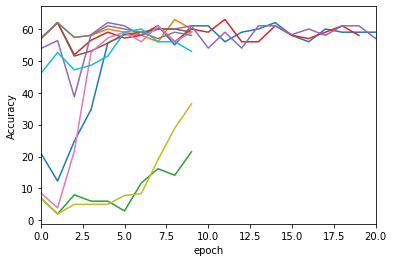

In [12]:
from matplotlib import pyplot as plt

dfs = analysis.fetch_trial_dataframes()

# Plot by epoch
ax = None
for d in dfs.values():
    ax = d.accuracy.plot(ax=ax, legend=False)

plt.xlim((0, 20))
plt.xlabel("epoch"); plt.ylabel("Accuracy"); 

# Tune on one dataset

In [18]:
def train_heart(config):
  model = VanillaLightningNN(config)

  # Create the Tune Reporting Callback
  metrics = {"loss": "ptl/val_loss", "acc": "ptl/val_accuracy"}

  data_dir = "/content/gdrive/MyDrive/Classes/STATS 503/STATS503 Project/Heart Data/heart_50_50/"
  heart_data = HeartDataModule(data_dir, use_sample=False)
  trainer = pl.Trainer(max_epochs=10)
  trainer.fit(model, heart_data)

In [23]:
config = {
    "l1": tune.choice([32, 64, 128]),
    "l2": tune.choice([64, 128, 256]),
    "l3": tune.choice([64, 128, 256]),
    "lr": tune.loguniform(1e-4, 1e-1)
}

scheduler = ASHAScheduler(
        time_attr='training_iteration',
        metric="mean_accuracy",
        mode="max",
        grace_period=10,
        reduction_factor=2,
        brackets=5
        )

reporter = CLIReporter(metric_columns=["loss", "mean_accuracy", "training_iteration"])

analysis = tune.run(
        train_heart,
        config=config,
        num_samples=10,
        resources_per_trial={"cpu": 2, "gpu": 0},
        progress_reporter=reporter,
        scheduler=scheduler,
        checkpoint_at_end=False,
        name="tune_heart")

== Status ==
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/6.98 GiB heap, 0.0/2.39 GiB objects
Result logdir: /root/ray_results/tune_heart
Number of trials: 10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+-------+------+------+------+-------------+
| Trial name              | status   | loc   |   l1 |   l2 |   l3 |          lr |
|-------------------------+----------+-------+------+------+------+-------------|
| train_heart_33f67_00000 | RUNNING  |       |   64 |   64 |  256 | 0.000729952 |
| train_heart_33f67_00001 | PENDING  |       |   32 |  128 |  256 | 0.0255516   |
| train_heart_33f67_00002 | PENDING  |       |   32 |  256 |   64 | 0.0350931   |
| train_hear

(pid=6443) GPU available: False, used: False
(pid=6443) TPU available: False, using: 0 TPU cores
(pid=6443) IPU available: False, using: 0 IPUs
(pid=6443) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=6443)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=6443) Missing logger folder: /root/ray_results/tune_heart/train_heart_33f67_00000_0_l1=64,l2=64,l3=256,lr=0.00072995_2022-04-21_20-04-08/lightning_logs
(pid=6443) 
(pid=6443)   | Name | Type   | Params
(pid=6443) --------------------------------
(pid=6443) 0 | fc1  | Linear | 1.5 K 
(pid=6443) 1 | fc2  | Linear | 4.2 K 
(pid=6443) 2 | fc3  | Linear | 16.6 K
(pid=6443) 3 | fc4  | Linear | 257   
(pid=6443) --------------------------------
(pid=6443) 22.6 K    Trainable params
(pid=6443) 0     

Epoch 0:  38%|███▊      | 280/744 [00:04<00:08, 57.01it/s, loss=0.577, v_num=0]
Result for train_heart_33f67_00000:
  accuracy: 31.6875
  date: 2022-04-21_20-04-22
  done: false
  experiment_id: 0efc33cd27e84a58aa49a9ac96e7dfc4
  experiment_tag: 0_l1=64,l2=64,l3=256,lr=0.00072995
  hostname: 41de635eabbd
  iterations_since_restore: 284
  loss: tensor(0.5091, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 6443
  time_since_restore: 5.524295330047607
  time_this_iter_s: 0.02718329429626465
  time_total_s: 5.524295330047607
  timestamp: 1650571462
  timesteps_since_restore: 0
  training_iteration: 284
  trial_id: 33f67_00000
  
== Status ==
Memory usage on this node: 2.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPU

(pid=6498) GPU available: False, used: False
(pid=6498) TPU available: False, using: 0 TPU cores
(pid=6498) IPU available: False, using: 0 IPUs
(pid=6498) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=6498)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=6498) Missing logger folder: /root/ray_results/tune_heart/train_heart_33f67_00001_1_l1=32,l2=128,l3=256,lr=0.025552_2022-04-21_20-06-32/lightning_logs
(pid=6498) 
(pid=6498)   | Name | Type   | Params
(pid=6498) --------------------------------
(pid=6498) 0 | fc1  | Linear | 768   
(pid=6498) 1 | fc2  | Linear | 4.2 K 
(pid=6498) 2 | fc3  | Linear | 33.0 K
(pid=6498) 3 | fc4  | Linear | 257   
(pid=6498) --------------------------------
(pid=6498) 38.3 K    Trainable params
(pid=6498) 0      

Epoch 0:  35%|███▍      | 260/744 [00:04<00:08, 55.86it/s, loss=50.6, v_num=0]
Result for train_heart_33f67_00001:
  accuracy: 28.0
  date: 2022-04-21_20-06-42
  done: false
  experiment_id: eabe240968e74399b2671a4f030301f2
  experiment_tag: 1_l1=32,l2=128,l3=256,lr=0.025552
  hostname: 41de635eabbd
  iterations_since_restore: 280
  loss: tensor(56.2500, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 6498
  time_since_restore: 5.225273847579956
  time_this_iter_s: 0.01642751693725586
  time_total_s: 5.225273847579956
  timestamp: 1650571602
  timesteps_since_restore: 0
  training_iteration: 280
  trial_id: 33f67_00001
  
== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0

(pid=6558) GPU available: False, used: False
(pid=6558) TPU available: False, using: 0 TPU cores
(pid=6558) IPU available: False, using: 0 IPUs
(pid=6558) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=6558)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=6558) Missing logger folder: /root/ray_results/tune_heart/train_heart_33f67_00002_2_l1=32,l2=256,l3=64,lr=0.035093_2022-04-21_20-08-52/lightning_logs
(pid=6558) 
(pid=6558)   | Name | Type   | Params
(pid=6558) --------------------------------
(pid=6558) 0 | fc1  | Linear | 768   
(pid=6558) 1 | fc2  | Linear | 8.4 K 
(pid=6558) 2 | fc3  | Linear | 16.4 K
(pid=6558) 3 | fc4  | Linear | 65    
(pid=6558) --------------------------------
(pid=6558) 25.7 K    Trainable params
(pid=6558) 0       

Epoch 0:  35%|███▍      | 260/744 [00:04<00:08, 55.97it/s, loss=0.604, v_num=0]
Result for train_heart_33f67_00002:
  accuracy: 34.5
  date: 2022-04-21_20-09-02
  done: false
  experiment_id: 63023b6822e9417784cb50e965d9a222
  experiment_tag: 2_l1=32,l2=256,l3=64,lr=0.035093
  hostname: 41de635eabbd
  iterations_since_restore: 283
  loss: tensor(0.4817, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 6558
  time_since_restore: 5.220775842666626
  time_this_iter_s: 0.024770498275756836
  time_total_s: 5.220775842666626
  timestamp: 1650571742
  timesteps_since_restore: 0
  training_iteration: 283
  trial_id: 33f67_00002
  
== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0

(pid=6612) GPU available: False, used: False
(pid=6612) TPU available: False, using: 0 TPU cores
(pid=6612) IPU available: False, using: 0 IPUs
(pid=6612) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=6612)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=6612) Missing logger folder: /root/ray_results/tune_heart/train_heart_33f67_00003_3_l1=128,l2=64,l3=64,lr=0.021302_2022-04-21_20-11-09/lightning_logs
(pid=6612) 
(pid=6612)   | Name | Type   | Params
(pid=6612) --------------------------------
(pid=6612) 0 | fc1  | Linear | 3.1 K 
(pid=6612) 1 | fc2  | Linear | 8.3 K 
(pid=6612) 2 | fc3  | Linear | 4.2 K 
(pid=6612) 3 | fc4  | Linear | 65    
(pid=6612) --------------------------------
(pid=6612) 15.6 K    Trainable params
(pid=6612) 0       

Epoch 0:  40%|████      | 300/744 [00:04<00:07, 60.75it/s, loss=0.576, v_num=0]
Result for train_heart_33f67_00003:
  accuracy: 29.8125
  date: 2022-04-21_20-11-18
  done: false
  experiment_id: b8b67271869145808a0e76d1e010b2a1
  experiment_tag: 3_l1=128,l2=64,l3=64,lr=0.021302
  hostname: 41de635eabbd
  iterations_since_restore: 304
  loss: tensor(0.5916, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 6612
  time_since_restore: 5.262653827667236
  time_this_iter_s: 0.028295040130615234
  time_total_s: 5.262653827667236
  timestamp: 1650571878
  timesteps_since_restore: 0
  training_iteration: 304
  trial_id: 33f67_00003
  
== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs

(pid=6666) GPU available: False, used: False
(pid=6666) TPU available: False, using: 0 TPU cores
(pid=6666) IPU available: False, using: 0 IPUs
(pid=6666) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=6666)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=6666) Missing logger folder: /root/ray_results/tune_heart/train_heart_33f67_00004_4_l1=128,l2=256,l3=128,lr=0.0020049_2022-04-21_20-13-20/lightning_logs
(pid=6666) 
(pid=6666)   | Name | Type   | Params
(pid=6666) --------------------------------
(pid=6666) 0 | fc1  | Linear | 3.1 K 
(pid=6666) 1 | fc2  | Linear | 33.0 K
(pid=6666) 2 | fc3  | Linear | 32.9 K
(pid=6666) 3 | fc4  | Linear | 129   
(pid=6666) --------------------------------
(pid=6666) 69.1 K    Trainable params
(pid=6666) 0    

Epoch 0:  32%|███▏      | 240/744 [00:04<00:09, 51.66it/s, loss=0.552, v_num=0]
Result for train_heart_33f67_00004:
  accuracy: 33.5625
  date: 2022-04-21_20-13-29
  done: false
  experiment_id: bc465a59c00846c7a68122f3df051764
  experiment_tag: 4_l1=128,l2=256,l3=128,lr=0.0020049
  hostname: 41de635eabbd
  iterations_since_restore: 260
  loss: tensor(0.5117, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 6666
  time_since_restore: 5.236001253128052
  time_this_iter_s: 0.020472049713134766
  time_total_s: 5.236001253128052
  timestamp: 1650572009
  timesteps_since_restore: 0
  training_iteration: 260
  trial_id: 33f67_00004
  
== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 G

(pid=6726) GPU available: False, used: False
(pid=6726) TPU available: False, using: 0 TPU cores
(pid=6726) IPU available: False, using: 0 IPUs
(pid=6726) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=6726)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=6726) Missing logger folder: /root/ray_results/tune_heart/train_heart_33f67_00005_5_l1=128,l2=64,l3=64,lr=0.00062754_2022-04-21_20-15-51/lightning_logs
(pid=6726) 
(pid=6726)   | Name | Type   | Params
(pid=6726) --------------------------------
(pid=6726) 0 | fc1  | Linear | 3.1 K 
(pid=6726) 1 | fc2  | Linear | 8.3 K 
(pid=6726) 2 | fc3  | Linear | 4.2 K 
(pid=6726) 3 | fc4  | Linear | 65    
(pid=6726) --------------------------------
(pid=6726) 15.6 K    Trainable params
(pid=6726) 0     

Epoch 0:  38%|███▊      | 280/744 [00:04<00:07, 59.26it/s, loss=0.588, v_num=0]
Result for train_heart_33f67_00005:
  accuracy: 32.625
  date: 2022-04-21_20-16-00
  done: false
  experiment_id: e245d6a42a7d4abf9b866a7ffd0d28ea
  experiment_tag: 5_l1=128,l2=64,l3=64,lr=0.00062754
  hostname: 41de635eabbd
  iterations_since_restore: 296
  loss: tensor(0.6142, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 6726
  time_since_restore: 5.191505670547485
  time_this_iter_s: 0.03394317626953125
  time_total_s: 5.191505670547485
  timestamp: 1650572160
  timesteps_since_restore: 0
  training_iteration: 296
  trial_id: 33f67_00005
  
== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs

2022-04-21 20:18:05,771	WARNING worker.py:1070 -- The actor or task with ID ffffffffffffffffb1225e9e01000000 is pending and cannot currently be scheduled. It requires {CPU: 2.000000} for execution and {CPU: 2.000000} for placement, but this node only has remaining {node:172.28.0.2: 1.000000}, {CPU: 2.000000}, {memory: 6.982422 GiB}, {object_store_memory: 2.392578 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
2022-04-21 20:18:06,256	INFO (unknown file):0 -- gc.collect() freed 11712 refs in 0.38654133600175555 seconds


Result for train_heart_33f67_00006:
  accuracy: 25.0
  date: 2022-04-21_20-18-10
  done: false
  experiment_id: ae41de35a8244698927bda7019cdaf91
  experiment_tag: 6_l1=128,l2=256,l3=128,lr=0.00010055
  hostname: 41de635eabbd
  iterations_since_restore: 1
  loss: tensor(0.7570)
  node_ip: 172.28.0.2
  pid: 6780
  time_since_restore: 0.2040727138519287
  time_this_iter_s: 0.2040727138519287
  time_total_s: 0.2040727138519287
  timestamp: 1650572290
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 33f67_00006
  
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]
== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/6.98 GiB heap, 0.0/2.39 GiB object

(pid=6780) GPU available: False, used: False
(pid=6780) TPU available: False, using: 0 TPU cores
(pid=6780) IPU available: False, using: 0 IPUs
(pid=6780) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=6780)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=6780) Missing logger folder: /root/ray_results/tune_heart/train_heart_33f67_00006_6_l1=128,l2=256,l3=128,lr=0.00010055_2022-04-21_20-18-05/lightning_logs
(pid=6780) 
(pid=6780)   | Name | Type   | Params
(pid=6780) --------------------------------
(pid=6780) 0 | fc1  | Linear | 3.1 K 
(pid=6780) 1 | fc2  | Linear | 33.0 K
(pid=6780) 2 | fc3  | Linear | 32.9 K
(pid=6780) 3 | fc4  | Linear | 129   
(pid=6780) --------------------------------
(pid=6780) 69.1 K    Trainable params
(pid=6780) 0   

Epoch 0:  32%|███▏      | 240/744 [00:04<00:09, 52.12it/s, loss=0.632, v_num=0]
Result for train_heart_33f67_00006:
  accuracy: 34.0
  date: 2022-04-21_20-18-15
  done: false
  experiment_id: ae41de35a8244698927bda7019cdaf91
  experiment_tag: 6_l1=128,l2=256,l3=128,lr=0.00010055
  hostname: 41de635eabbd
  iterations_since_restore: 261
  loss: tensor(0.6259, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 6780
  time_since_restore: 5.210521697998047
  time_this_iter_s: 0.01885247230529785
  time_total_s: 5.210521697998047
  timestamp: 1650572295
  timesteps_since_restore: 0
  training_iteration: 261
  trial_id: 33f67_00006
  
== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs

2022-04-21 20:20:36,922	INFO (unknown file):0 -- gc.collect() freed 1151 refs in 0.3068400689990085 seconds


Result for train_heart_33f67_00007:
  accuracy: 36.15625
  date: 2022-04-21_20-20-40
  done: false
  experiment_id: 736a40768bff448aa492a224afdf4bb8
  experiment_tag: 7_l1=64,l2=64,l3=64,lr=0.0024319
  hostname: 41de635eabbd
  iterations_since_restore: 1
  loss: tensor(0.6973)
  node_ip: 172.28.0.2
  pid: 6838
  time_since_restore: 0.20697355270385742
  time_this_iter_s: 0.20697355270385742
  time_total_s: 0.20697355270385742
  timestamp: 1650572440
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 33f67_00007
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/6.98 GiB heap, 0.0/2.39 GiB objec

(pid=6838) GPU available: False, used: False
(pid=6838) TPU available: False, using: 0 TPU cores
(pid=6838) IPU available: False, using: 0 IPUs
(pid=6838) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=6838)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=6838) Missing logger folder: /root/ray_results/tune_heart/train_heart_33f67_00007_7_l1=64,l2=64,l3=64,lr=0.0024319_2022-04-21_20-20-36/lightning_logs
(pid=6838) 
(pid=6838)   | Name | Type   | Params
(pid=6838) --------------------------------
(pid=6838) 0 | fc1  | Linear | 1.5 K 
(pid=6838) 1 | fc2  | Linear | 4.2 K 
(pid=6838) 2 | fc3  | Linear | 4.2 K 
(pid=6838) 3 | fc4  | Linear | 65    
(pid=6838) --------------------------------
(pid=6838) 9.9 K     Trainable params
(pid=6838) 0       

Epoch 0:  38%|███▊      | 280/744 [00:04<00:07, 60.34it/s, loss=0.563, v_num=0]
Result for train_heart_33f67_00007:
  accuracy: 31.3125
  date: 2022-04-21_20-20-45
  done: false
  experiment_id: 736a40768bff448aa492a224afdf4bb8
  experiment_tag: 7_l1=64,l2=64,l3=64,lr=0.0024319
  hostname: 41de635eabbd
  iterations_since_restore: 301
  loss: tensor(0.6632, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 6838
  time_since_restore: 5.224891662597656
  time_this_iter_s: 0.015525102615356445
  time_total_s: 5.224891662597656
  timestamp: 1650572445
  timesteps_since_restore: 0
  training_iteration: 301
  trial_id: 33f67_00007
  
== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs

(pid=6889) GPU available: False, used: False
(pid=6889) TPU available: False, using: 0 TPU cores
(pid=6889) IPU available: False, using: 0 IPUs
(pid=6889) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=6889)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=6889) Missing logger folder: /root/ray_results/tune_heart/train_heart_33f67_00008_8_l1=64,l2=256,l3=256,lr=0.01043_2022-04-21_20-22-47/lightning_logs
(pid=6889) 
(pid=6889)   | Name | Type   | Params
(pid=6889) --------------------------------
(pid=6889) 0 | fc1  | Linear | 1.5 K 
(pid=6889) 1 | fc2  | Linear | 16.6 K
(pid=6889) 2 | fc3  | Linear | 65.8 K
(pid=6889) 3 | fc4  | Linear | 257   
(pid=6889) --------------------------------
(pid=6889) 84.2 K    Trainable params
(pid=6889) 0       

Epoch 0:  35%|███▍      | 260/744 [00:04<00:09, 53.44it/s, loss=0.59, v_num=0] 
Result for train_heart_33f67_00008:
  accuracy: 32.0
  date: 2022-04-21_20-22-57
  done: false
  experiment_id: a93b33a2e5b44761aef8e53578d92a8f
  experiment_tag: 8_l1=64,l2=256,l3=256,lr=0.01043
  hostname: 41de635eabbd
  iterations_since_restore: 267
  loss: tensor(0.6279, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 6889
  time_since_restore: 5.203841924667358
  time_this_iter_s: 0.017977476119995117
  time_total_s: 5.203841924667358
  timestamp: 1650572577
  timesteps_since_restore: 0
  training_iteration: 267
  trial_id: 33f67_00008
  
== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 GPUs, 0

(pid=6945) GPU available: False, used: False
(pid=6945) TPU available: False, using: 0 TPU cores
(pid=6945) IPU available: False, using: 0 IPUs
(pid=6945) /usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
(pid=6945)   f"DataModule.{name} has already been called, so it will not be called again. "
(pid=6945) Missing logger folder: /root/ray_results/tune_heart/train_heart_33f67_00009_9_l1=32,l2=256,l3=256,lr=0.00018053_2022-04-21_20-25-25/lightning_logs
(pid=6945) 
(pid=6945)   | Name | Type   | Params
(pid=6945) --------------------------------
(pid=6945) 0 | fc1  | Linear | 768   
(pid=6945) 1 | fc2  | Linear | 8.4 K 
(pid=6945) 2 | fc3  | Linear | 65.8 K
(pid=6945) 3 | fc4  | Linear | 257   
(pid=6945) --------------------------------
(pid=6945) 75.3 K    Trainable params
(pid=6945) 0    

Epoch 0:  32%|███▏      | 240/744 [00:04<00:09, 50.87it/s, loss=0.629, v_num=0]
Result for train_heart_33f67_00009:
  accuracy: 33.71875
  date: 2022-04-21_20-25-34
  done: false
  experiment_id: 3c1f27cde0cf4e209fcd9435a6277121
  experiment_tag: 9_l1=32,l2=256,l3=256,lr=0.00018053
  hostname: 41de635eabbd
  iterations_since_restore: 256
  loss: tensor(0.6290, requires_grad=True)
  node_ip: 172.28.0.2
  pid: 6945
  time_since_restore: 5.201090574264526
  time_this_iter_s: 0.020850658416748047
  time_total_s: 5.201090574264526
  timestamp: 1650572734
  timesteps_since_restore: 0
  training_iteration: 256
  trial_id: 33f67_00009
  
== Status ==
Memory usage on this node: 2.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None
Bracket: Iter 80.000: None | Iter 40.000: None
Bracket: Iter 80.000: None
Bracket: 
Resources requested: 2/2 CPUs, 0/0 

In [30]:
analysis.get_best_trial("accuracy", "max", "last").config

{'l1': 32, 'l2': 128, 'l3': 256, 'lr': 0.02555157793183902}

# Plot the results

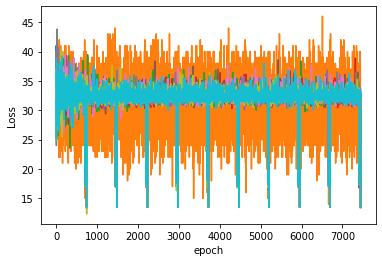

In [32]:
from matplotlib import pyplot as plt

dfs = analysis.fetch_trial_dataframes()

# Plot by epoch
ax = None
for d in dfs.values():
    ax = d.accuracy.plot(ax=ax, legend=False)
plt.xlabel("epoch"); plt.ylabel("Loss"); 

# Train on the entire dataset

Model with the best parameters hard-coded

In [80]:
import torch.nn as nn
import torch.nn.functional as F


class VanillaNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(23, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 256)
    self.fc4 = nn.Linear(256, 1)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.dropout(x)
    x = self.fc1(x)
    x = torch.relu(self.fc2(x))
    x = self.dropout(x)
    x = torch.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x


def train_model(model, train_dataloader, epochs=10):
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.006)

  for epoch in range(epochs):
      # print("Starting epoch: {}".format(epoch))  
      running_loss = 0.0
      for i, data in enumerate(train_dataloader):
          inputs, labels = data

          optimizer.zero_grad()
          outputs = model(inputs).float()

          loss = criterion(outputs, labels.unsqueeze(1))
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      print(f'{epoch + 1} loss: {running_loss / 2000:.3f}')
          

  print('Finished Training')
  return model


def test_model(model, test_dataloader):
  correct = 0
  total = 0

  all_labels, all_predicted = [], []
  predicted_probs = []

  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_dataloader:
          inputs, labels = data
          predicted = model(inputs).reshape(-1)
          
          total += labels.size(0)

          correct += (predicted.round() == labels).sum().item()

          all_labels.extend(labels.detach().numpy())
          predicted_probs.extend(predicted.detach().numpy())
          all_predicted.extend(predicted.round().detach().numpy())

  print("Accuracy of the network on the test set: {}".format(correct / total))
  return all_labels, all_predicted, predicted_probs

In [81]:
# Test lower thresholds to deal with class imbalance
def get_predictions(probs, threshold=0.2):
  preds = []
  for prob in probs:
    if prob >= threshold:
      preds.append(1)
    else:
      preds.append(0)
  return preds

## Subsampled

In [86]:
data_dir = "/content/gdrive/MyDrive/Classes/STATS 503/STATS503 Project/Heart Data/heart_subsampled/"
heart_data_sub = HeartDataModule(data_dir, use_sample=False)
model = VanillaNN()
model = train_model(model, heart_data_sub.train_dataloader())
all_labels, all_predicted, predicted_probs = test_model(model, heart_data_sub.test_dataloader())

1 loss: 0.062
2 loss: 0.053
3 loss: 0.052
4 loss: 0.052
5 loss: 0.052
6 loss: 0.051
7 loss: 0.052
8 loss: 0.051
9 loss: 0.052
10 loss: 0.055
Finished Training
Accuracy of the network on the test set: 0.917057902973396


In [87]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_predicted))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      4688
         1.0       0.00      0.00      0.00       424

    accuracy                           0.92      5112
   macro avg       0.46      0.50      0.48      5112
weighted avg       0.84      0.92      0.88      5112



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
new_preds = get_predictions(predicted_probs, threshold=0.2)
print(classification_report(all_labels, new_preds))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      4688
         1.0       0.32      0.12      0.17       424

    accuracy                           0.91      5112
   macro avg       0.62      0.55      0.56      5112
weighted avg       0.87      0.91      0.89      5112



## SMOTEd

In [89]:
data_dir = "/content/gdrive/MyDrive/Classes/STATS 503/STATS503 Project/Heart Data/heart_smoted/"
heart_data_sub = HeartDataModule(data_dir, use_sample=False)
model = VanillaNN()
model = train_model(model, heart_data_sub.train_dataloader())
all_labels, all_predicted, predicted_probs = test_model(model, heart_data_sub.test_dataloader())
print(classification_report(all_labels, all_predicted))

1 loss: 0.256
2 loss: 0.207
3 loss: 0.204
4 loss: 0.198
5 loss: 0.200
6 loss: 0.203
7 loss: 0.199
8 loss: 0.198
9 loss: 0.196
10 loss: 0.196
Finished Training
Accuracy of the network on the test set: 0.721244131455399
              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83      4688
         1.0       0.16      0.56      0.25       424

    accuracy                           0.72      5112
   macro avg       0.55      0.65      0.54      5112
weighted avg       0.88      0.72      0.78      5112



In [90]:
new_preds = get_predictions(predicted_probs, threshold=0.2)
print(classification_report(all_labels, new_preds))

              precision    recall  f1-score   support

         0.0       0.97      0.37      0.54      4688
         1.0       0.11      0.86      0.20       424

    accuracy                           0.41      5112
   macro avg       0.54      0.62      0.37      5112
weighted avg       0.90      0.41      0.51      5112



## 50-50

In [91]:
data_dir = "/content/gdrive/MyDrive/Classes/STATS 503/STATS503 Project/Heart Data/heart_50_50/"
heart_data_50 = HeartDataModule(data_dir, use_sample=False)
model = VanillaNN()
model = train_model(model, heart_data_50.train_dataloader())
all_labels, all_predicted, predicted_probs = test_model(model, heart_data_50.test_dataloader())
print(classification_report(all_labels, all_predicted))

1 loss: 0.240
2 loss: 0.213
3 loss: 0.214
4 loss: 0.215
5 loss: 0.214
6 loss: 0.216
7 loss: 0.213
8 loss: 0.214
9 loss: 0.214
10 loss: 0.212
Finished Training
Accuracy of the network on the test set: 0.6857332155477032
              precision    recall  f1-score   support

         0.0       0.69      0.71      0.70      4711
         1.0       0.68      0.66      0.67      4345

    accuracy                           0.69      9056
   macro avg       0.69      0.68      0.68      9056
weighted avg       0.69      0.69      0.69      9056



In [92]:
new_preds = get_predictions(predicted_probs, threshold=0.2)
print(classification_report(all_labels, new_preds))

              precision    recall  f1-score   support

         0.0       0.85      0.02      0.03      4711
         1.0       0.48      1.00      0.65      4345

    accuracy                           0.49      9056
   macro avg       0.66      0.51      0.34      9056
weighted avg       0.67      0.49      0.33      9056

